In [8]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()


In [9]:
from tensorflow.keras.applications import inception_v3
from tensorflow.keras import backend as K

K.set_learning_phase(0) # 모델 훈련 연산을 비활성화

model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

C:\Users\rjsdu\anaconda3\envs\tf2.4\lib\site-packages\tensorflow\python\keras\backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [10]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [11]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])
loss = K.variable(0.) # 손실을 정의하고 각 층의 기여 분을 이 스칼라 변수에 추가
for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output # 층의 출력을 얻는다.
    
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling # 층 특성의 L2 노름 제곱을 손실에 추가한다.

In [12]:
import tensorflow as tf

dream = model.input # 생성된 딥드림 이미지 저장

grads = K.gradients(loss, dream)[0] # 손실에 대한 딥드림 이미지의 그래디언트를 계산

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7) # 그래디언트 정규화

outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

# 이 함수는 경사 상승법을 여러 번 반복하여 수행한다.
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...', i, '번째 손실 :', loss_value)
    return x

In [13]:
import scipy
from tensorflow.keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    image.save_img(fname, pil_img)

def preprocess_image(image_path): # 사진을 열고 크기를 줄이고 인셉션 V3가 인식하는 텐서 포맷으로 변환하는 유틸리티 함수
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x): # 넘파일 배열을 적절한 이미지 포맷으로 변환하는 유틸리티 함수
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [14]:
import numpy as np

step = 0.01 # 경사 상승법 단계 크기
num_octave = 3 # 경사 상승법을 실행할 스케일 단계 횟수
octave_scale = 1.4 # 스케일 간의 크기 비율
iterations = 20 # 스케일 단계마다 수행할 경사 상승법 횟수

max_loss = 10. # 손실이 10보다 커지면 이상한 그림이 되기 때문에 경사 상승법 과정을 중지한다.

base_image_path = '../datasets/original_photo_deep_dream.jpg' # 사용할 이미지 경로

img = preprocess_image(base_image_path) # 기본 이미지를 넘파이 배열로 로드

original_shape = img.shape[1:3]
successive_shapes = [original_shape] # 경사 상승법을 실행할 스케일 크기를 정의한 튜플의 리스트를 준비
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1] # 리스트를 크기 순으로 뒤집는다.

original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0]) # 이미지의 넘파이 배열을 가장 작은 스케일로 변경한다.

for shape in successive_shapes:
    print('처리할 이미지 크기', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape) # 작게 줄인 원본 이미지의 스케일을 높인다. (픽셀 경계가 보일 것이다.)
    same_size_original = resize_img(original_img, shape) # 이 크기에 해당하는 원본 이미지의 고해상도 버전을 계산한다.
    lost_detail = same_size_original - upscaled_shrunk_original_img # 이 두 이미지의 차이가 스케일을 높였을 때 손실된 디테일
    img += lost_detail # 손실된 디테일을 딥드림 이미지에 다시 주입
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='../datasets/final_dream.png')

처리할 이미지 크기 (178, 178)
... 0 번째 손실 : 0.6596663
... 1 번째 손실 : 0.6596663
... 2 번째 손실 : 0.6596663
... 3 번째 손실 : 0.6596663
... 4 번째 손실 : 0.6596663
... 5 번째 손실 : 0.6596663
... 6 번째 손실 : 0.6596663
... 7 번째 손실 : 0.6596663
... 8 번째 손실 : 0.6596663
... 9 번째 손실 : 0.6596663
... 10 번째 손실 : 0.6596663
... 11 번째 손실 : 0.6596663
... 12 번째 손실 : 0.6596663
... 13 번째 손실 : 0.6596663
... 14 번째 손실 : 0.6596663
... 15 번째 손실 : 0.6596663
... 16 번째 손실 : 0.6596663
... 17 번째 손실 : 0.6596663
... 18 번째 손실 : 0.6596663
... 19 번째 손실 : 0.6596663
처리할 이미지 크기 (250, 250)
... 0 번째 손실 : 0.9669634
... 1 번째 손실 : 0.9669634
... 2 번째 손실 : 0.9669634
... 3 번째 손실 : 0.9669634
... 4 번째 손실 : 0.9669634
... 5 번째 손실 : 0.9669634
... 6 번째 손실 : 0.9669634
... 7 번째 손실 : 0.9669634
... 8 번째 손실 : 0.9669634
... 9 번째 손실 : 0.9669634
... 10 번째 손실 : 0.9669634
... 11 번째 손실 : 0.9669634
... 12 번째 손실 : 0.9669634
... 13 번째 손실 : 0.9669634
... 14 번째 손실 : 0.9669634
... 15 번째 손실 : 0.9669634
... 16 번째 손실 : 0.9669634
... 17 번째 손실 : 0.9669634
... 18 번째 손실 : 0.9669634
.

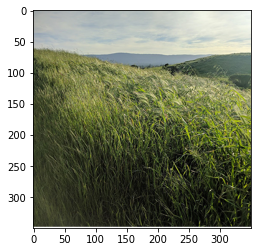

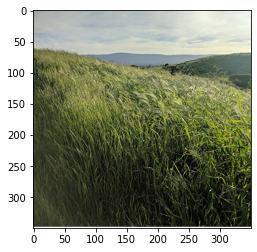

In [16]:
from matplotlib import pyplot as plt

plt.imshow(plt.imread(base_image_path))
plt.figure()

plt.imshow(deprocess_image(np.copy(img)))
plt.show()